In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cv
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator,img_to_array

In [2]:
path = "../input/kermany2018/OCT2017 /"
base_dir = os.path.join("../input/kermany2018/OCT2017 /") 
print('base directory ---->', os.listdir(path))

# os.listdir(path) is used for listing the directories under the folder

base directory ----> ['val', 'test', 'train']


In [3]:
test_dir = os.path.join(path + "test/")
print(os.listdir(test_dir))

['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [4]:
train_dir = os.path.join(path + "train/")
print(os.listdir(train_dir))# This path is used for listing the directories under the folder

['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [5]:
val_dir = os.path.join(path + "val/")
print(os.listdir(val_dir))# This path is used for listing the directories under the folder

['DRUSEN', 'CNV', 'NORMAL', 'DME']


In [6]:
def image_show(x):
    for i in range(3):
        plt.subplot(330 + 1 + i)
        batch = x.next()
        image = batch[0].astype('uint8')
        plt.imshow(image)
    plt.show()

# Data Augumentation

In [7]:
# Zoom
train_zoom = ImageDataGenerator(
    zoom_range = 0.5,
    horizontal_flip = True)

In [8]:
# Flipping the Image
train_flip = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True)

ImageDataGenerator() is used for Generating Data with data Augumentation

In [9]:
image = load_img('../input/kermany2018/OCT2017 /test/CNV/CNV-1290410-1.jpeg')
f = img_to_array(image)
sample = np.expand_dims(f,axis = 0)
print('Image size', sample.shape)

Image size (1, 496, 512, 3)


np.expand_dims() Insert a new axis that will appear at the axis position in the expanded array shape.

load_img() is used for lading image in  PIL Format

Zoom Image


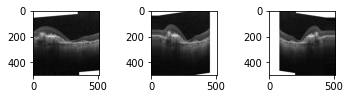

In [10]:
print("Zoom Image")
train_generator_zoom = train_zoom.flow(sample, batch_size = 1)
zoom = image_show(train_generator_zoom)

Flip Image


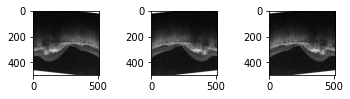

In [11]:
print("Flip Image")
train_generator_flip = train_flip.flow(sample,batch_size = 1)
flip = image_show(train_generator_flip)

In [12]:
img_height = 224
img_width = 224
batch_size = 64

In [13]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height,img_width),
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training')

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory(
    val_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 83484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


flow_from_directory() Takes the path to a directory & generates batches of augmented data.

In [14]:
# from keras.models import  Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Activation,Dropout,Flatten,Dense, InputLayer

# Model

In [15]:
model = Sequential()
model.add((Conv2D(32,kernel_size = 5,input_shape=(img_height,img_width,3),activation="relu")))
model.add((Conv2D(32,kernel_size = 5,activation="relu")))
model.add((Conv2D(64,kernel_size = 4,activation="relu")))
model.add((Conv2D(64,kernel_size = 4,activation="relu")))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add((Conv2D(32,kernel_size = 5,activation="relu")))
model.add((Conv2D(64,kernel_size = 4,activation="relu")))
model.add((Conv2D(64,kernel_size = 4,activation="relu")))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add((Conv2D(32,kernel_size = 4,activation="relu")))
model.add(MaxPooling2D(pool_size=2))
model.add((Conv2D(64,kernel_size = 3,activation="relu")))
model.add((Conv2D(64,kernel_size = 3,activation="relu")))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(4,activation="softmax"))

# model.summary()

model.compile(optimizer = SGD(lr=0.001,momentum = 0.9),loss="categorical_crossentropy",metrics=['accuracy'])
# model.build(input_shape = (img_height,img_width,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 216, 216, 32)      25632     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 213, 213, 64)      32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 210, 210, 64)      65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 105, 105, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 105, 105, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 101, 101, 32)      5

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


# training model

In [16]:
from keras.callbacks import EarlyStopping
earlystop = EarlyStopping(monitor='val_acc', patience=5)

In [17]:
history = model.fit_generator(generator = train_generator,
                             steps_per_epoch = train_generator.samples//800,
                             validation_data = validation_generator,
                             validation_steps = test_generator.samples//16,
                             epochs = 100,
                             verbose = 1,
                             max_queue_size = 100,
                             workers = 4,
                             use_multiprocessing = True,
                             callbacks=[earlystop])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
104/104 [==============================] - 232s 2s/step - loss: 1.2957 - accuracy: 0.4425 - val_loss: 1.4966 - val_accuracy: 0.2500
Epoch 2/100
104/104 [==============================] - 241s 2s/step - loss: 1.2351 - accuracy: 0.4405 - val_loss: 1.5129 - val_accuracy: 0.2500
Epoch 3/100
104/104 [==============================] - 229s 2s/step - loss: 1.2213 - accuracy: 0.4525 - val_loss: 1.4955 - val_accuracy: 0.2500
Epoch 4/100
104/104 [==============================] - 234s 2s/step - loss: 1.2215 - accuracy: 0.4482 - val_loss: 1.5245 - val_accuracy: 0.2500
Epoch 5/100
104/104 [==============================] - 234s 2s/step - loss: 1.2209 - accuracy: 0.4528 - val_loss: 1.4849 - val_accuracy: 0.2500
Epoch 6/100
104/104 [==============================] - 237s 2s/step - loss: 1.2133 - accuracy: 0.4671 - val_loss: 1.4363 - val_accuracy: 0.4115
Epoch 7/100
104/104 [==============================] - 235s 2s/step - loss: 1.2018 - accuracy: 0.4893 - val_loss: 1.4482 - val_accuracy:

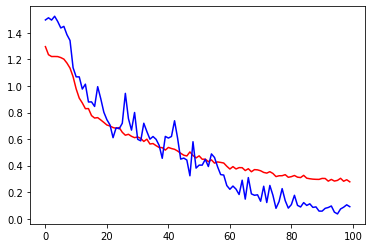

In [18]:
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'], 'b')

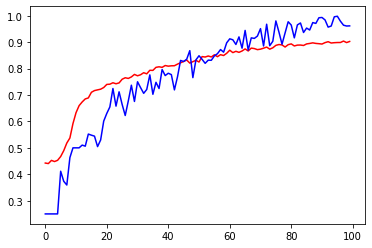

In [19]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['val_accuracy'], 'b')

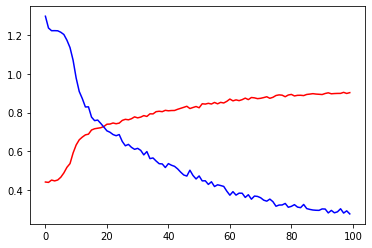

In [20]:
plt.plot(history.history['accuracy'], 'r')
plt.plot(history.history['loss'],'b')

In [21]:
model.save('my_model.h5')